In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

In [63]:
# x1 input

df = pd.read_csv('datasets/CNN_parameter_dataset.csv', encoding='utf-8')
int_flow = df.copy()

#preparing the dataset for spliting into features and labels 
int_flow.columns = [col.strip() for col in df.columns]
int_flow.drop(['Sample','Cavity','Pulse width'], axis=1, inplace=True)
int_flow.drop(['Pulse rms','Pulse pkpk'], axis=1, inplace=True)
int_flow['cavity width(mm)'] = int_flow['cavity width(mm)']*1000
#int_flow = sklearn.utils.shuffle(int_flow)
int_flow.head()

,Voltage,Flow rate,Duty cycle,Pulse period,Laser energy,cavity width(mm),cavity depth(µm)
0,25,0.47,20,20,0,2285.0,72.1
1,25,0.47,20,20,0,2199.0,68.2
2,25,0.47,20,20,0,2108.0,67.2
3,25,0.47,20,20,0,2233.0,61.2
4,25,0.47,20,20,0,2046.0,52.2


In [64]:
# x2 input

X2= []
path = r'C:\Users\nikam\Desktop\Academics\Thesis\Internal_flow_experiments\Internal_flow_current_data'   
for folder in (os.listdir(path)):
    dfs = []
    
    for file in (os.listdir(path + '\\'+folder)):
        df = pd.read_csv(path + '\\'+folder + '\\'+file, encoding='unicode_escape', sep='\t' )
        dfs.append(df)
    new_df = pd.concat(dfs)
    for i in range(0,len(new_df),15):
        _df = new_df[i:i+15].copy()
        _df = _df.reset_index(drop=True)
        idx = _df['Pulse rms [A]'].index[_df['Pulse rms [A]'].apply(np.isnan)]
        
        if len(idx)>0: 
            for ii in idx:
                if ii == 0: 
                    replacing_val = _df['Pulse rms [A]'][ii+1]
                elif ii == 14:
                     replacing_val = _df['Pulse rms [A]'][ii-1]   
                else:
                    replacing_val = (_df['Pulse rms [A]'][ii-1]+_df['Pulse rms [A]'][ii+1])/2
                _df.loc[ii,'Pulse rms [A]'] = replacing_val
        X2.append(_df.iloc[:,-2:].to_numpy())        
        
X2 = np.asarray(X2, dtype=np.float16)
X2 =np.expand_dims(X2,axis=1)

In [65]:
#initializing X(features) and y(labels)
X1 = int_flow.drop(['cavity width(mm)','cavity depth(µm)'], axis=1).to_numpy()
#X1 =np.expand_dims(X1,axis=1)
y = int_flow[['cavity width(mm)']].values

In [66]:
from sklearn import model_selection
X1_train, X1_test,X2_train, X2_test, y_train, y_test = model_selection.train_test_split(X1, X2, y, test_size=0.2, random_state=1)
X1_train_1, X1_dev, X2_train_1, X2_dev, y_train_1, y_dev = model_selection.train_test_split(X1_train, X2_train, y_train, test_size=0.2, random_state=1)

In [49]:
class nncnn(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 10)        
        self.cnn1 = nn.Conv2d(1, 5, (2,2))
        
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x1,x2):
        x1 = F.relu(self.fc1(x1))
        
        x2 = self.cnn1(x2).view(x1.size(0),-1)
        #print(x1.shape, x2.shape)
        x_joined = torch.cat([x1,x2], dim=1)
        #print(x1.shape, x2.shape, x_joined.shape)
        x_joined = F.relu(self.fc2(x_joined))
        x_joined = F.relu(self.fc3(x_joined))
        x_joined = self.fc4(x_joined)

        return x_joined

In [50]:
m = nncnn()
m

nncnn(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (cnn1): Conv2d(1, 5, kernel_size=(2, 2), stride=(1, 1))
  (fc2): Linear(in_features=80, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [67]:
#training the neuralnetwork model

X1_train_1 = torch.tensor(X1_train_1, dtype=torch.float64)
X2_train_1 = torch.tensor(X2_train_1, dtype=torch.float64)
y_train_1 = torch.tensor(y_train_1)

X1_dev = torch.tensor(X1_dev, dtype=torch.float64)
X2_dev = torch.tensor(X2_dev, dtype=torch.float64)
y_dev = torch.tensor(y_dev)


In [68]:
from tqdm import tqdm

net = nncnn()

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.02)

# to track the training loss as the model trains
t_l = []
# to track the validation loss as the model trains
d_l = []

#initialize the early_stopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in tqdm(range(10000)):# 10000 full passes over the data        
    net.zero_grad() # sets gradients to 0 before loss calc. You will do this likely every step.
    output = net(X1_train_1.float(), X2_train_1.float()) # pass in the training batch 
    loss = loss_function(output, y_train_1.float()) # calc and grab the loss value
    loss.backward() # apply this loss backwards thru the network's parameters
    optimizer.step() # attempt to optimize weights to account for loss/gradients
    if epoch%5 == 0: 
        with torch.no_grad():
            y_predict = net(X1_dev.float(), X2_dev.float())
            dev_error = loss_function(y_predict, y_dev.float())
            #print(f'train_loss..:{loss.item()} dev_loss..:{dev_error.item()} ')
            t_l.append(loss.item())
            d_l.append(dev_error.item())
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(dev_error, net)
            if early_stopping.early_stop:
                print("Early stopping")
                break  
            #print(loss) # print loss. We hope loss (train_loss..:{loss.item()} a measure of wrong-ness) declines!

          

  0%|▎                                                                             | 46/10000 [00:00<00:22, 450.73it/s]

Validation loss decreased (inf --> 5106172.000000).  Saving model ...
Validation loss decreased (5106172.000000 --> 4800970.000000).  Saving model ...
Validation loss decreased (4800970.000000 --> 3159737.750000).  Saving model ...
Validation loss decreased (3159737.750000 --> 135839.406250).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
Validation loss decreased (135839.406250 --> 135486.000000).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
Validation loss decreased (135486.000000 --> 130697.210938).  Saving model ...
Validation loss decreased (130697.210938 --> 127709.789062).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (1277

  2%|█▏                                                                           | 154/10000 [00:00<00:19, 506.76it/s]

Validation loss decreased (126229.453125 --> 123512.445312).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (123512.445312 --> 123432.289062).  Saving model ...
Validation loss decreased (123432.289062 --> 121822.992188).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (121822.992188 --> 121159.890625).  Saving model ...
Validation loss decreased (121159.890625 --> 119998.023438).  Saving model ...
Validation loss decreased (119998.023438 --> 119751.054688).  Saving model ...
Validation loss decreased (119751.054688 --> 118429.242188).  Saving model ...
Validation loss decreased (118429.242188 --> 117410.679688).  Saving model ...
Validation loss decreased (117410.679688 --> 116666.820312).  Saving model ...
Validation loss decreased (116666.820312 --> 115455.476562).  Saving model ...
Validation loss decreased (115455.476562 --> 114556.656250).  Saving model ...
Validation loss decreased (114556.656250 --> 113662.328125). 

  3%|██                                                                           | 260/10000 [00:00<00:18, 514.01it/s]

Validation loss decreased (107560.257812 --> 106749.960938).  Saving model ...
Validation loss decreased (106749.960938 --> 105944.242188).  Saving model ...
Validation loss decreased (105944.242188 --> 105170.218750).  Saving model ...
Validation loss decreased (105170.218750 --> 104395.796875).  Saving model ...
Validation loss decreased (104395.796875 --> 103851.257812).  Saving model ...
Validation loss decreased (103851.257812 --> 103325.210938).  Saving model ...
Validation loss decreased (103325.210938 --> 102772.164062).  Saving model ...
Validation loss decreased (102772.164062 --> 102235.398438).  Saving model ...
Validation loss decreased (102235.398438 --> 101690.000000).  Saving model ...
Validation loss decreased (101690.000000 --> 101184.484375).  Saving model ...
Validation loss decreased (101184.484375 --> 100693.750000).  Saving model ...
Validation loss decreased (100693.750000 --> 100234.125000).  Saving model ...
Validation loss decreased (100234.125000 --> 99800.7

  4%|██▊                                                                          | 363/10000 [00:00<00:19, 500.50it/s]

Validation loss decreased (97431.867188 --> 97189.312500).  Saving model ...
Validation loss decreased (97189.312500 --> 96970.210938).  Saving model ...
Validation loss decreased (96970.210938 --> 96773.085938).  Saving model ...
Validation loss decreased (96773.085938 --> 96598.062500).  Saving model ...
Validation loss decreased (96598.062500 --> 96443.468750).  Saving model ...
Validation loss decreased (96443.468750 --> 96309.382812).  Saving model ...
Validation loss decreased (96309.382812 --> 96194.757812).  Saving model ...
Validation loss decreased (96194.757812 --> 96099.335938).  Saving model ...
Validation loss decreased (96099.335938 --> 96022.257812).  Saving model ...
Validation loss decreased (96022.257812 --> 95874.843750).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (95874.843750 --> 95721.093750).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
Validation lo

  5%|███▌                                                                         | 464/10000 [00:00<00:19, 480.96it/s]

Validation loss decreased (95005.625000 --> 94967.468750).  Saving model ...
Validation loss decreased (94967.468750 --> 94674.726562).  Saving model ...
Validation loss decreased (94674.726562 --> 94643.054688).  Saving model ...
Validation loss decreased (94643.054688 --> 94419.054688).  Saving model ...
Validation loss decreased (94419.054688 --> 94306.976562).  Saving model ...
Validation loss decreased (94306.976562 --> 94179.421875).  Saving model ...
Validation loss decreased (94179.421875 --> 94081.335938).  Saving model ...
Validation loss decreased (94081.335938 --> 94046.992188).  Saving model ...
Validation loss decreased (94046.992188 --> 93900.257812).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (93900.257812 --> 93806.859375).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (93806.859375 --> 93738.460938).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping

  6%|████▎                                                                        | 560/10000 [00:01<00:20, 460.43it/s]

EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
EarlyStopping counter: 7 out of 50
EarlyStopping counter: 8 out of 50
EarlyStopping counter: 9 out of 50
EarlyStopping counter: 10 out of 50
EarlyStopping counter: 11 out of 50
EarlyStopping counter: 12 out of 50
EarlyStopping counter: 13 out of 50
EarlyStopping counter: 14 out of 50
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping counter: 18 out of 50
EarlyStopping counter: 19 out of 50
EarlyStopping counter: 20 out of 50


  6%|████▋                                                                        | 613/10000 [00:01<00:19, 477.80it/s]

EarlyStopping counter: 21 out of 50
EarlyStopping counter: 22 out of 50
EarlyStopping counter: 23 out of 50
EarlyStopping counter: 24 out of 50
EarlyStopping counter: 25 out of 50
EarlyStopping counter: 26 out of 50
EarlyStopping counter: 27 out of 50
EarlyStopping counter: 28 out of 50
EarlyStopping counter: 29 out of 50
EarlyStopping counter: 30 out of 50
EarlyStopping counter: 31 out of 50
EarlyStopping counter: 32 out of 50
EarlyStopping counter: 33 out of 50
EarlyStopping counter: 34 out of 50
EarlyStopping counter: 35 out of 50
EarlyStopping counter: 36 out of 50
EarlyStopping counter: 37 out of 50
EarlyStopping counter: 38 out of 50
EarlyStopping counter: 39 out of 50


  7%|█████▍                                                                       | 705/10000 [00:01<00:19, 479.27it/s]

EarlyStopping counter: 40 out of 50
EarlyStopping counter: 41 out of 50
EarlyStopping counter: 42 out of 50
EarlyStopping counter: 43 out of 50
EarlyStopping counter: 44 out of 50
EarlyStopping counter: 45 out of 50
EarlyStopping counter: 46 out of 50
EarlyStopping counter: 47 out of 50
EarlyStopping counter: 48 out of 50
EarlyStopping counter: 49 out of 50
EarlyStopping counter: 50 out of 50
Early stopping


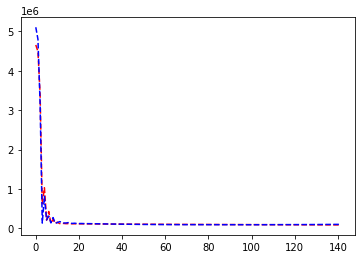

In [69]:
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
#t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t_l,'r--', d_l,'b--')
plt.show()

In [70]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

X1_test = torch.tensor(X1_test)
X2_test = torch.tensor(X2_test)
y_test = torch.tensor(y_test)

y_predict_1 = net(X1_test.float(), X2_test.float())
error = loss_function(y_predict_1, y_test.float())

print(error.item())
for a in (list(zip(y_test,y_predict_1))):
    print(a)
    
print(r2_score(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))
#print(r2_score(y_test.detach().numpy()[:,1], y_predict_1.detach().numpy()[:,1]))

print('MAPE for width: ', mean_absolute_percentage_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))
#print('MAPE for depth: ', mean_absolute_percentage_error(y_test.detach().numpy()[:,1], y_predict_1.detach().numpy()[:,1]))

print('MSE for width: ', mean_squared_error(y_test.detach().numpy()[:,0], y_predict_1.detach().numpy()[:,0]))
#print('MSE for depth: ', mean_squared_error(y_test.detach().numpy()[:,1], y_predict_1.detach().numpy()[:,1]))

101228.4140625
(tensor([991.], dtype=torch.float64), tensor([1318.5577], grad_fn=<UnbindBackward0>))
(tensor([2658.], dtype=torch.float64), tensor([2359.4265], grad_fn=<UnbindBackward0>))
(tensor([2880.], dtype=torch.float64), tensor([2892.9070], grad_fn=<UnbindBackward0>))
(tensor([2424.], dtype=torch.float64), tensor([2503.8391], grad_fn=<UnbindBackward0>))
(tensor([1772.], dtype=torch.float64), tensor([1604.2592], grad_fn=<UnbindBackward0>))
(tensor([2538.], dtype=torch.float64), tensor([2573.2671], grad_fn=<UnbindBackward0>))
(tensor([2677.], dtype=torch.float64), tensor([2874.6394], grad_fn=<UnbindBackward0>))
(tensor([2785.], dtype=torch.float64), tensor([2640.1541], grad_fn=<UnbindBackward0>))
(tensor([3021.], dtype=torch.float64), tensor([2256.9751], grad_fn=<UnbindBackward0>))
(tensor([1823.], dtype=torch.float64), tensor([1998.3326], grad_fn=<UnbindBackward0>))
(tensor([1738.], dtype=torch.float64), tensor([1844.7240], grad_fn=<UnbindBackward0>))
(tensor([1920.], dtype=torch.

In [11]:
import os, pathlib, random

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



class EarlyStopping:
	"""Early stops the training if validation loss doesn't improve after a given patience."""
	def __init__(self, patience, verbose=False, delta=0, save_path='checkpoint.pt'):
		"""
		Args:
			patience (int): How long to wait after last time validation loss improved.
							Default: 7
			verbose (bool): If True, prints a message for each validation loss improvement.
							Default: False
			delta (float): Minimum change in the monitored quantity to qualify as an improvement.
							Default: 0
		"""
		self.patience = patience
		self.verbose = verbose
		self.counter = 0
		self.best_score = None
		self.early_stop = False
		self.val_loss_min = np.inf
		self.delta = delta
		self.save_path = save_path
		os.makedirs(pathlib.Path(self.save_path).parent, exist_ok=True)

	def __call__(self, val_loss, model):

		score = -val_loss

		if self.best_score is None:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
		elif score < self.best_score - self.delta:
			self.counter += 1
			print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
			if self.counter >= self.patience:
				self.early_stop = True
		else:
			self.best_score = score
			self.save_checkpoint(val_loss, model)
			self.counter = 0

	def save_checkpoint(self, val_loss, model):
		"""Saves model when validation loss decrease."""
		if self.verbose:
			print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
		torch.save(model.state_dict(), self.save_path)
		self.val_loss_min = val_loss